# Анализ клиентов магазина «В один клик»

# Описание задачи

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

# Описание данных

Данные для работы находятся в нескольких таблицах. Нажмите на название файла, чтобы его скачать.

`market_file.csv`

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

* `id` — номер покупателя в корпоративной базе данных.
* `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
* `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
* `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
* `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
* `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
* `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv`

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

* `id` — номер покупателя в корпоративной базе данных.
* `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* `Выручка` — сумма выручки за период.

`market_time.csv`

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

* `id` — номер покупателя в корпоративной базе данных.
* `Период` — название периода, во время которого зафиксировано общее время.
* `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv`

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

* `id` — номер покупателя в корпоративной базе данных.
* `Прибыль` — значение прибыли.

Импорт необходимых библиотек

In [75]:
!pip install shap -q
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

In [76]:
import pandas as pd
import time
import copy
import shap
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Загрузка данных

Загрузка файлов

In [ ]:
market_file = pd.read_csv('./market_file.csv')
market_money = pd.read_csv('./market_money.csv')
market_time = pd.read_csv('./market_time.csv')
money = pd.read_csv('./money.csv', sep=';', decimal = ',')

Вывод первых строк каждой из таблиц

In [78]:
display(market_file.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [79]:
display(market_money.head())

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [80]:
display(market_time.head())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [81]:
display(money.head())

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


В таблице `market_time` есть опечатки в столбце `Период`

`Вывод Шаг 1:`

Данные из файлов были загружены в таблицы pandas. Данные в таблицах соответствуют описанию.

### Предобработка данных

`Проверка наличия явных дупликатов`

In [82]:
table_names = ['market_file', 'market_money', 'market_time', 'money']
tables = [market_file, market_money, market_time, money]

In [83]:
for i in range(len(table_names)):
    print(f'Количество дупликатов в таблице ' + \
    f'{table_names[i]} = {tables[i].duplicated().sum()}')

Количество дупликатов в таблице market_file = 0
Количество дупликатов в таблице market_money = 0
Количество дупликатов в таблице market_time = 0
Количество дупликатов в таблице money = 0


Явные дупликаты отсутствуют

`Проверка наличия пропусков в данных`

In [84]:
for i in range(len(table_names)):
    print(f'Количество пропусков в таблице ' + \
    f'{table_names[i]}: \n{tables[i].isna().sum()}\n')

Количество пропусков в таблице market_file: 
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Количество пропусков в таблице market_money: 
id         0
Период     0
Выручка    0
dtype: int64

Количество пропусков в таблице market_time: 
id        0
Период    0
минут     0
dtype: int64

Количество пропусков в таблице money: 
id         0
Прибыль    0
dtype: int64



Пропуски в данных отсутствуют

`Проверка типов данных`

Таблица `market_file`

In [85]:
display(market_file.head(3))
print(market_file.info())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В таблице `market_file` все типы верные

Таблица `market_money`

In [86]:
i=1
print(f'Таблица {table_names[i]}')
display(tables[i].head(3))
print(tables[i].info())
print('\n\n')

Таблица market_money


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None





В таблице `market_money` все типы верные

Таблица `market_time`

In [87]:
display(market_time.head(3))
print(market_time.info())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


В таблице `market_time` все типы верные

Сразу изменим опечатку в значениях столбца `Период` в таблице `market_time`

In [88]:
print(market_time['Период'].unique())

['текущий_месяц' 'предыдцщий_месяц']


In [89]:
market_time.loc[market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'

Проверка

In [90]:
print(market_time['Период'].unique())

['текущий_месяц' 'предыдущий_месяц']


Опечатки больше нет

Таблица `money`

In [91]:
display(money.head(3))
print(money.info())

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


In [92]:
print(money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


Тип изменился

`Вывод Шаг 2:`

Пропусков и явных дупликатов в загруженных таблицах не было обнаружено. Все столбцы имеют верные типы.

### Исследовательский анализ данных

Таблица `market_file`

In [93]:
categorial_columns = ['Покупательская активность', 
                      'Тип сервиса', 
                      'Разрешить сообщать',
                      'Популярная_категория'
                     ]

numerical_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 
         'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит']

In [94]:
market_file[categorial_columns].describe()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Популярная_категория
count,1300,1300,1300,1300
unique,2,3,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,914,962,330


In [95]:
market_file[numerical_columns].describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


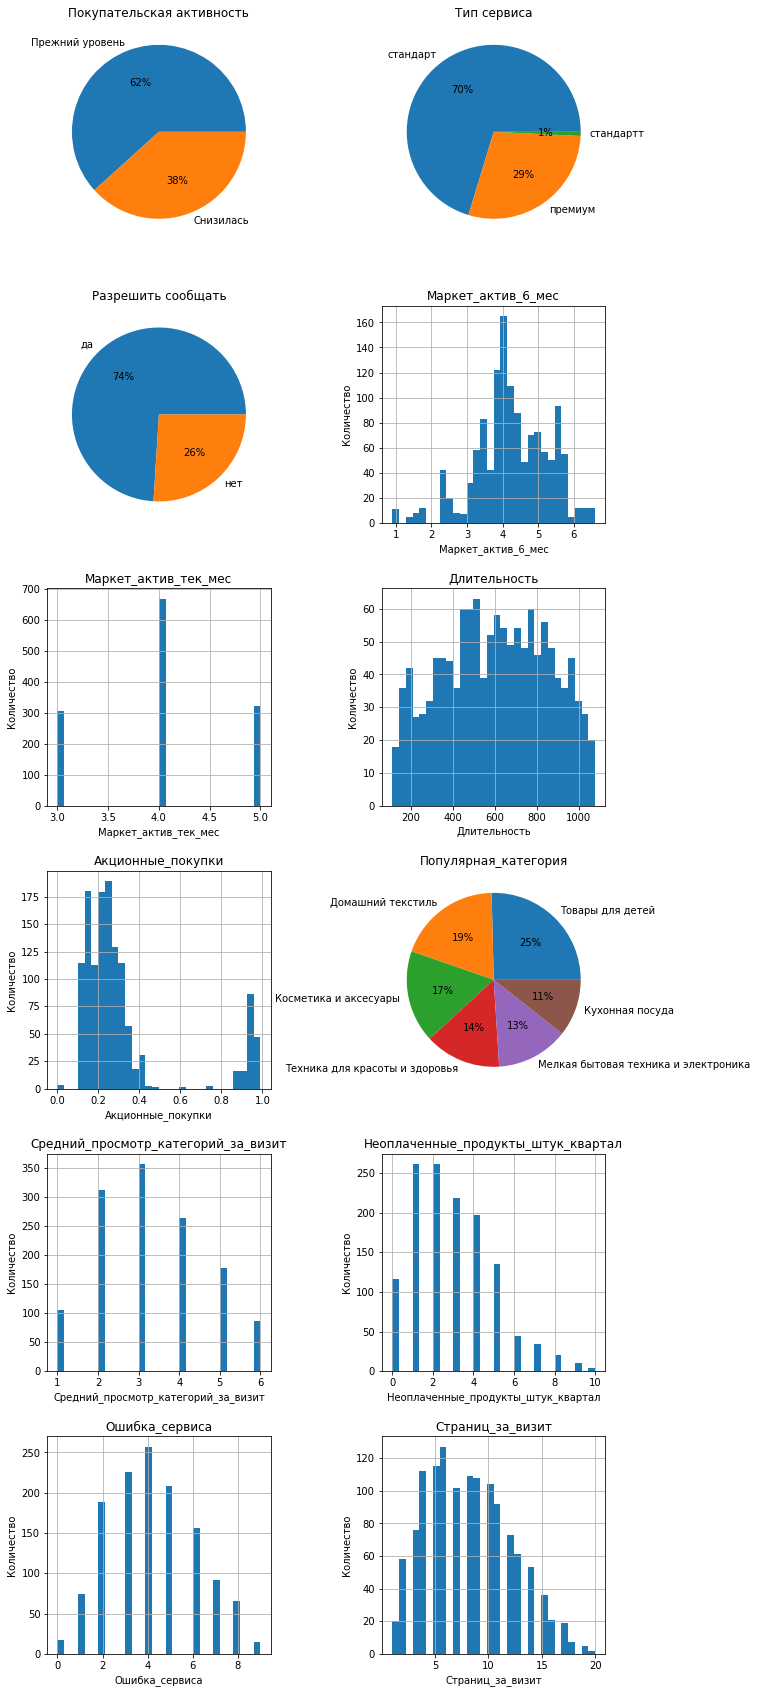

In [96]:
categorial_columns = ['Покупательская активность', 
                      'Тип сервиса', 
                      'Разрешить сообщать',
                      'Популярная_категория'
                     ]

numerical_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 
         'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит']

df_columns = market_file.columns.tolist()
df_columns.remove('id')
#print(df_columns)

fig = plt.figure(figsize=(10, 30));
for i, column in enumerate(df_columns):
    plt.subplot(6, 2, i+1)
    if column in categorial_columns:
        market_file[column].value_counts().plot(
    kind= 'pie',
    title= df_columns[i],
    autopct = "%.0f%%",
    ylabel= ""
)
    else:
        plt.hist(market_file[column], bins=30)
        plt.title(df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show();

In [97]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

* `Покупательская активность` - хотим предсказать, нет дисбаланса классов.
* `Тип сервиса` - около 30% с типов сервиса *премиум*, нужно удалить значение с опечаткой *стандартт*.
* `Разрешить сообщать` - 26% разрешили сообщать.
* `Маркет_актив_6_мес` - от 1 до 6,5 маркетинговых коммуникаций со средним примерно 4,5 коммуникации в месяц.
* `Маркет_актив_тек_мес` - 3, 4 или 5 с преобладанием значения 4.
* `Длительность` - от 100 до 1100 дней, все значения одинаково часто встречаются.
* `Акционные_покупки` - от 0 до 1, два пика - 0,2 и 0,9.
* `Популярная_категория` - 6 разных категорий, нет очень редких.
* `Средний_просмотр_категорий_за_визит` - от 1 до 6 со средним около 3, распределение похоже на нормальное.
* `Неоплаченные_продукты_штук_квартал` - от 0 до 10, наиболее частые значения - 1 и 2.
* `Ошибка_сервиса` - от 0 до 9 со средним около 4, похоже на нормальное распределение.
* `Страниц_за_визит` - от 1 до 20 со средним около 7.

Выбросов или редких значений на графиках не обнаружено, все значения находятся в приемлемых диапазонах.

Единственное, что нужно исправить - значение `стандартт` в столбце `Тип сервиса`. Заменяем его на `стандарт`.

In [98]:
market_file.loc[market_file['Тип сервиса'] == 'стандартт', \
                'Тип сервиса'] = 'стандарт'

Проверка

In [99]:
print(market_file['Тип сервиса'].unique())

['премиум' 'стандарт']


Удалили опечатку

Таблица `market_money`

In [100]:
market_money.drop(columns=['id']).describe()

,Выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


Гистограмма значений столбца `Выручка`

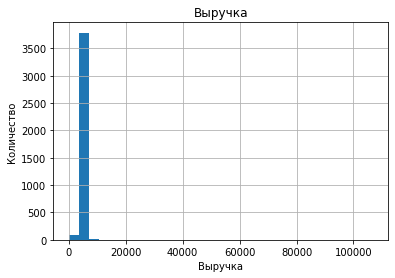

In [101]:
plt.hist(market_money['Выручка'], bins=30)
plt.title('Выручка')
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.grid()
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show();

Гистограмма значений столбца `Выручка`, больших 10000

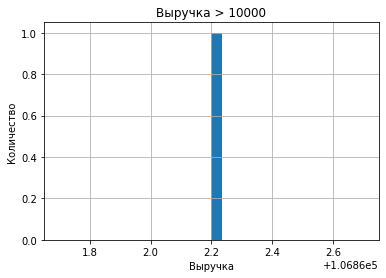

In [102]:
plt.hist(market_money.loc[market_money['Выручка'] > 10000,'Выручка'], bins=30)
plt.title('Выручка > 10000')
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.grid()
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show();

Это очевидный выброс, удалим его

In [103]:
print(market_money.loc[market_money['Выручка'] > 10000, 'id'])

98    215380
Name: id, dtype: int64


In [104]:
bad_id = 215380
display(market_money[market_money['id'] == bad_id])

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [105]:
market_file = market_file[market_file['id'] != bad_id]
market_money = market_money[market_money['id'] != bad_id]
market_time = market_time[market_time['id'] != bad_id]
money = money[money['id'] != bad_id]

Проверяем гистограмму

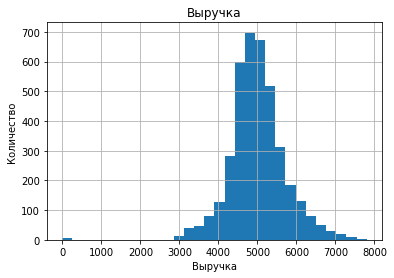

In [106]:
plt.hist(market_money['Выручка'], bins=30)
plt.title('Выручка')
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.grid()
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show();

Теперь видим выбросы около нуля, проверим их.

In [107]:
display(market_money[market_money['Выручка'] < 2500])

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Удаляем данные об этих клиентах.

In [108]:
bad_ids = [215348, 215357, 215359]
market_file = market_file[(market_file['id'] != bad_ids[0]) & \
                          (market_file['id'] != bad_ids[1]) & (market_file['id'] != bad_ids[2])]
market_money = market_money[(market_money['id'] != bad_ids[0]) & \
                          (market_money['id'] != bad_ids[1]) & (market_money['id'] != bad_ids[2])]
market_time = market_time[(market_time['id'] != bad_ids[0]) & \
                          (market_time['id'] != bad_ids[1]) & (market_time['id'] != bad_ids[2])]
money = money[(money['id'] != bad_ids[0]) & \
                          (money['id'] != bad_ids[1]) & (money['id'] != bad_ids[2])]

Проверка

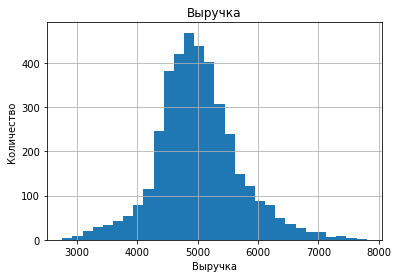

In [109]:
plt.hist(market_money['Выручка'], bins=30)
plt.title('Выручка')
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.grid()
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show();

Таблица `market_time`

In [110]:
market_time['Период'].describe()

count                 2592
unique                   2
top       предыдущий_месяц
freq                  1296
Name: Период, dtype: object

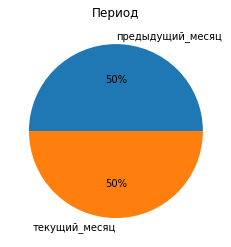

In [111]:
market_time['Период'].value_counts().plot(
    kind= 'pie',
    title= 'Период',
    autopct = "%.0f%%",
    ylabel= ""
)

plt.show();

Все верно, для каждого пользователя информация о текущем и предыдущем месяцах.

In [112]:
market_time['минут'].describe()

count    2592.000000
mean       13.340664
std         4.083469
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

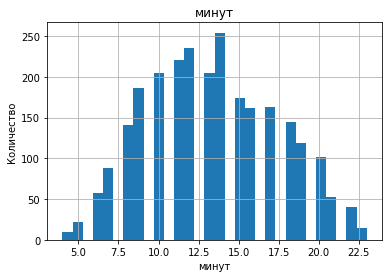

In [113]:
plt.hist(market_time['минут'], bins=30)
plt.title('минут')
plt.xlabel('минут')
plt.ylabel('Количество')
plt.grid()
plt.show();

Изменяется от 4 до 23 со средним около 13, распределение похоже на нормальное.

Таблица `money`

In [114]:
money['Прибыль'].describe()

count    1296.000000
mean        3.997701
std         1.011198
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

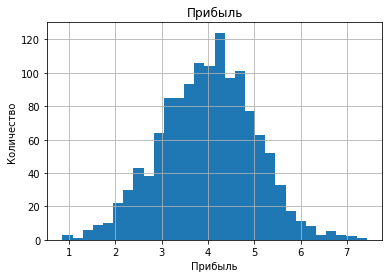

In [115]:
plt.hist(money['Прибыль'], bins=30)
plt.title('Прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Количество')
plt.grid()
plt.show();

Изменяется от 0.86 до 7.43 со средним 4, распределение похоже на нормальное.

`Распределения признаков с учетом целевого`

Таблица `market_file`

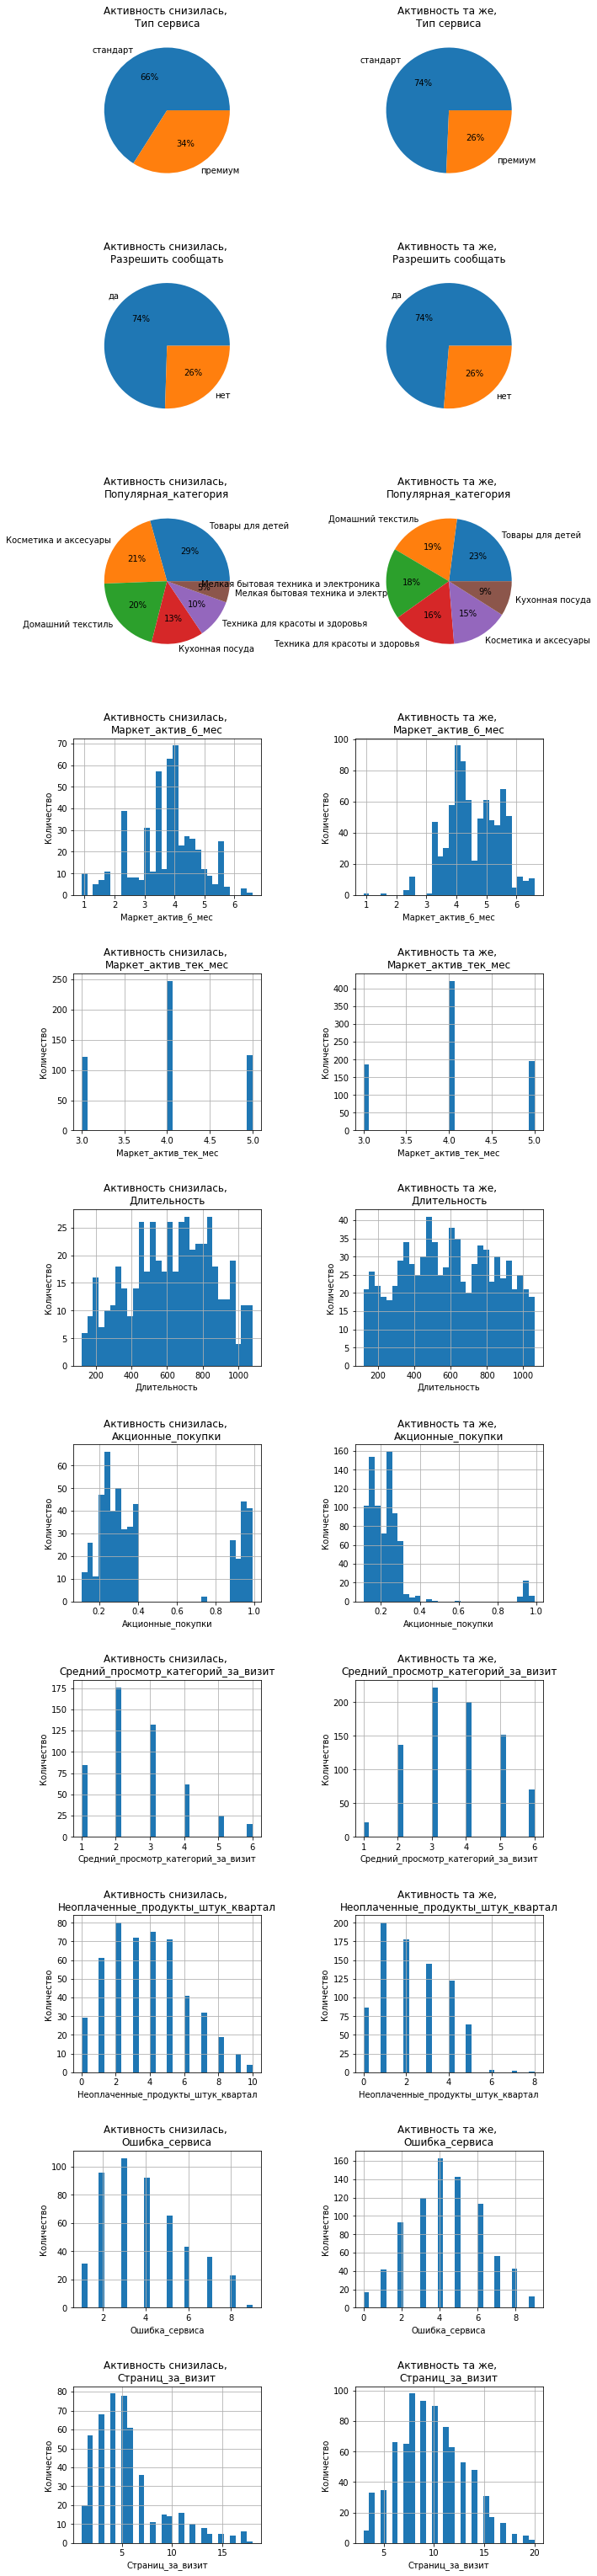

In [116]:
categorial_columns = [
                      'Тип сервиса', 
                      'Разрешить сообщать',
                      'Популярная_категория'
                     ]

numerical_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 
         'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит']

df_columns = []
df_columns.extend(categorial_columns)
df_columns.extend(numerical_columns)
#print(df_columns)

fig = plt.figure(figsize=(10, 60));
for i, column in enumerate(df_columns):
    data1 = market_file.loc[market_file['Покупательская активность'] == 'Снизилась', column]
    data2 = market_file.loc[market_file['Покупательская активность'] != 'Снизилась', column]
    plt.subplot(12, 2, 2*i+1)
    if column in categorial_columns:
        data1.value_counts().plot(
    kind= 'pie',
    title= 'Активность снизилась, \n' + column,
    autopct = "%.0f%%",
    ylabel= ""
)
    else:
        plt.hist(data1, bins=30)
        plt.title('Активность снизилась, \n' + column)
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
        
    plt.subplot(12, 2, 2*i+2)
    if column in categorial_columns:
        data2.value_counts().plot(
    kind= 'pie',
    title= 'Активность та же, \n' + column,
    autopct = "%.0f%%",
    ylabel= ""
)
    else:
        plt.hist(data2, bins=30)
        plt.title('Активность та же, \n' + column)
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
        
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show();

* `Тип сервиса` - среди тех, у кого активность *Снизилась*, немного больше людей с типом сервиса премиум, но разница не очень большая.
* `Разрешить сообщать` - доли разрешивших сообщать среди пользователей со снизившейся активностью и оставшейся на том же уровне, равны.
* `Маркет_актив_6_мес` - для сниженной активности видим пользователей со значением столбца ниже 2, которых нет для неизменного уровня активности; для неизменного уровня активности есть пользователи со значением столбца выше 6, подобные значения не характерны для сниженной активности. Средние значению на левой гистограмме около 4, на правой - около 5.
* `Маркет_актив_тек_мес` - практически равные распределения.
* `Длительность` - гистограммы длительности почти не различаются.
* `Акционные_покупки` - средни пользователей со сниженной активностью заметна немалая часть, ориентированных на акционные покупки, причет для неизменной активности таких пользователей очень мало.
* `Популярная_категория` - доли категорий немного отличаются, но не слишком, чтобы делать выводы по этому признаку.
* `Средний_просмотр_категорий_за_визит` -  пользователи со сниженной активностью в среднем просматривают меньше категорий, что закономерно.
* `Неоплаченные_продукты_штук_квартал` - у пользователей со сниженной активностью число неоплаченных покупок в среднем выше.
* `Ошибка_сервиса` - на пользователей со сниженной активностью в среднем приходится меньше ошибок сервиса, что закономерно.
* `Страниц_за_визит` - пользователи со сниженной активностью в среднем посещают меньше страниц за визит, что закономерно.

Портрет покупателя, у которого снижается активность:
* `Маркет_актив_6_мес` - 4 и ниже.
* `Акционные_покупки` - почти все пользователи с высокой доле акционных покупок имеют сниженную активность.
* `Средний_просмотр_категорий_за_визит` - 1 или 2 категории.
* `Неоплаченные_продукты_штук_квартал` - все пользователи с более чем 4-мя неоплаченными продуктами имеют сниженную активность.
* `Страниц_за_визит` - 5 и меньше.

`Вывод Шаг 3:`

Были проанализированы распределения значений всех столбцов из загруженных таблиц. Выбросы были обнаружены только в столбце `Выручка` таблицы `market_money`, остальные столбца не имеют ни выбросов, ни редких значений и поэтому не требуют обработки.


### Объединение таблиц

Новые таблицы

In [117]:
market_money_curr = market_money[market_money['Период'] == 'текущий_месяц']
market_money_prev = market_money[market_money['Период'] == 'предыдущий_месяц']
display(market_money_curr.head(3))
display(market_money_prev.head(3))

,id,Период,Выручка
4,215349,текущий_месяц,4971.6
7,215350,текущий_месяц,5058.4
9,215351,текущий_месяц,6610.4


,id,Период,Выручка
5,215349,предыдущий_месяц,5216.0
8,215350,предыдущий_месяц,5457.5
10,215351,предыдущий_месяц,6158.0


In [118]:
market_time_curr = market_time[market_time['Период'] == 'текущий_месяц']
market_time_prev = market_time[market_time['Период'] == 'предыдущий_месяц']
display(market_time_curr.head(3))
display(market_time_prev.head(3))

,id,Период,минут
2,215349,текущий_месяц,10
4,215350,текущий_месяц,13
6,215351,текущий_месяц,13


,id,Период,минут
3,215349,предыдущий_месяц,12
5,215350,предыдущий_месяц,8
7,215351,предыдущий_месяц,11


Объединяем `market_file` и `market_money_curr`

In [119]:
market_file_curr = pd.merge(market_file, market_money_curr, how='left', on='id')
market_file_curr = market_file_curr.drop(columns=['Период'])
market_file_curr = market_file_curr\
.rename(columns={'Выручка':'Выручка_текущий_месяц'})
display(market_file_curr.head(3))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4


Объединяем `market_file_curr` и `market_money_prev`

In [120]:
market_curr_prev = pd.merge(market_file_curr, market_money_prev, \
                            how='left', on='id')
market_curr_prev = market_curr_prev.drop(columns=['Период'])
market_curr_prev = market_curr_prev.rename(columns={'Выручка':'Выручка_предыдуший_месяц'})
display(market_curr_prev.head(3))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдуший_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0


Объединяем `market_curr_prev` и `market_time_curr`

In [121]:
market = pd.merge(market_curr_prev, market_time_curr, how='left', on='id')
market = market.drop(columns=['Период'])
market = market.rename(columns={'минут':'минут_текущий_месяц'})
display(market.head(3))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдуший_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,13


Объединяем `market` и `market_time_prev`

In [122]:
market = pd.merge(market, market_time_prev, how='left', on='id')
market = market.drop(columns=['Период'])
market = market.rename(columns={'минут':'минут_предыдуший_месяц'})
display(market.head(3))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдуший_месяц,минут_текущий_месяц,минут_предыдуший_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,10,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,13,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,13,11


Объединяем `market` и `money`

In [123]:
market = pd.merge(market, money, how='left', on='id')
display(market.head(3))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдуший_месяц,минут_текущий_месяц,минут_предыдуший_месяц,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,10,12,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,13,8,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,13,11,4.87


Итоговая таблица

In [124]:
market.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдуший_месяц,минут_текущий_месяц,минут_предыдуший_месяц,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,10,12,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,13,8,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,13,11,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,11,8,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,10,10,3.95
5,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5869.6,5685.0,12,11,3.62
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3772.6,3263.0,10,12,5.26
7,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4566.4,4146.5,7,6,4.93
8,215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,4209.5,3488.0,10,14,3.06
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5834.9,5304.5,6,9,4.55


`Вывод Шаг 4:`

В таблицу `market_file` из таблиц `market_money` и `market_time` были добавлены данные о прибыли и времени, проведенном на сайте за предыдущий и текущий месяцы. Из таблицы `money` была добавлена прибыть компании от каждого пользователя.

In [125]:
print(market.shape)

(1296, 18)


### Корреляционный анализ

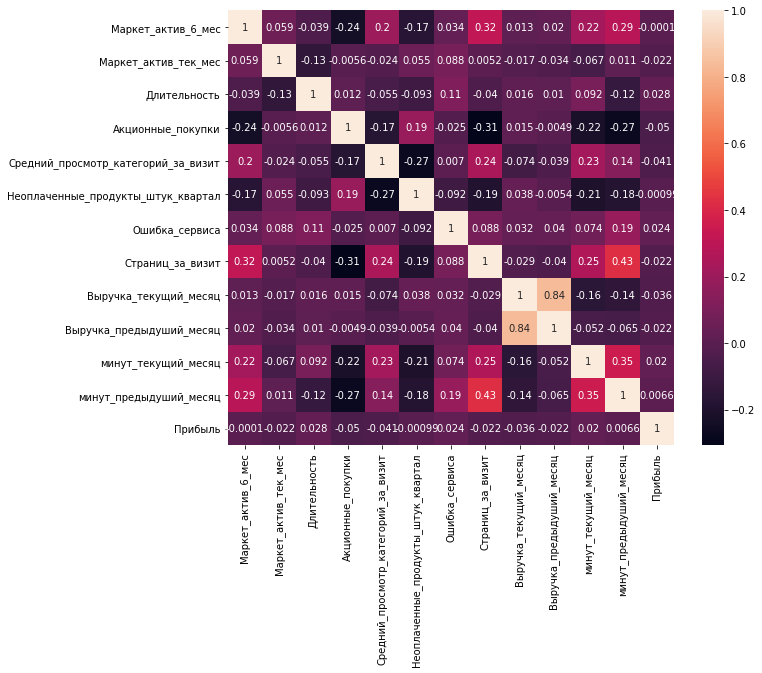

In [126]:
plt.figure(figsize=(10, 8))
sns.heatmap(market.drop(columns=['id']).corr(), annot=True);
plt.show();

Мультиколлинеарность не наблюдается, максимальное значение в матрице корреляции равно 0,43. Но это корреляции только для количественных признаков.

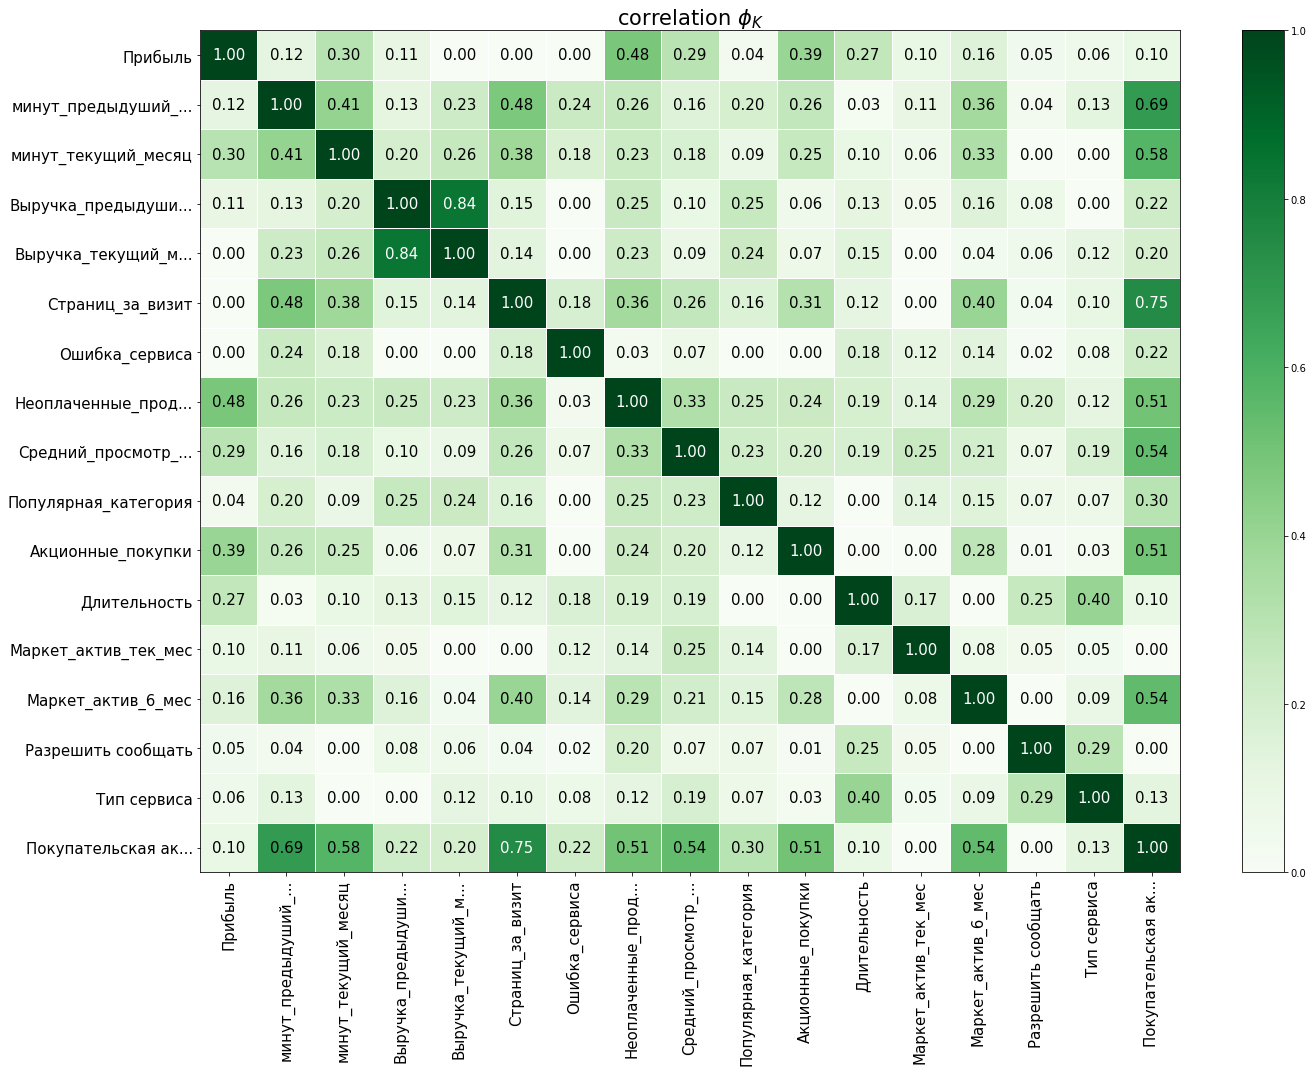

In [127]:
interval_cols = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', \
                 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', \
                 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', \
                 'Страниц_за_визит', 'Выручка_текущий_месяц', 'Выручка_предыдуший_месяц', \
                 'минут_текущий_месяц', 'минут_предыдуший_месяц']

phik_overview = phik_matrix(market.drop(['id'], axis=1), interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

В этой матрице также нет коллинеарных признаков, но теперь мы можем выявить признаки наиболее скоррелированные с целевым (`Покупательская активность`)
* `Страниц_за_визит` - корреляция 0,75
* `минут_предыдущий_месяц` - корреляция 0,69
* `минут_текущий_месяц` - корреляция 0,58
* `Средний_просмотр_категорий_за_визит` - корреляция 0,54
* `Маркет_актив_6_мес` - корреляция 0,54 
* `Акционные_покупки` - корреляция 0,51
* `Неоплаченные_продукты_штук_квартал` - корреляция 0,51

`Вывод Шаг 5:`

Был проведен корреляционный анализ признаков, было показано, что в таблице нет коллинеарных признаков. Также были выявлены признаки, наиболее скоррелированные с целевым: 
* `Страниц_за_визит` - корреляция -0,52
* `минут_предыдущий_месяц` - корреляция -0,5
* `Акционные_покупки` - корреляция 0,41
* `минут_текущий_месяц` - корреляция -0,41
* `Неоплаченные_продукты_штук_квартал` - корреляция 0,35
* `Маркет_актив_6_мес` - корреляция -0,4 

### Использование пайплайнов

In [128]:
market.head(3)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдуший_месяц,минут_текущий_месяц,минут_предыдуший_месяц,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,10,12,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,13,8,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,13,11,4.87


In [129]:
market.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_текущий_месяц', 'Выручка_предыдуший_месяц',
       'минут_текущий_месяц', 'минут_предыдуший_месяц', 'Прибыль'],
      dtype='object')

Разделение столбцов для их дальнейшего кодирования/скалирования

In [130]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [131]:
ohe_columns = ['Популярная_категория', 'Разрешить сообщать']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_текущий_месяц', 'Выручка_предыдуший_месяц',
       'минут_текущий_месяц', 'минут_предыдуший_месяц']

Пайплайн

In [132]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[ 
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

preprocessor = Pipeline([
    ('preprocessor', data_preprocessor)
])

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Параметры пайплайна

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(kernel='linear', probability=True,
            random_state=RANDOM_STATE
        )],
        'models__C': [10*i for i in range(-4, 4)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=10
)

Запуск

In [134]:
warnings.filterwarnings("ignore")

In [135]:
data = market.drop(columns=['id'])

X_train, X_test, example_train, example_test = train_test_split(
    data.drop(['Покупательская активность'], axis=1),
    data['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['Покупательская активность'])

label_encoder = LabelEncoder()
label_encoder.fit(example_train)

y_train = label_encoder.transform(example_train)
y_test = label_encoder.transform(example_test) 

randomized_search.fit(X_train, y_train);

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

y_test_prob = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_prob)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                   

`Вывод Шаг 6:`

Были обучены модели k-ближайших соседей, дерева решений, логистической регрессии и опорных векторов с варьирующимися значениями гиперпараметров. Для оценки качества моделей использовалась метрика `roc-auc`. Наилучшее значение метрики показала модель для метода опорных векторов со значением `C=9`.

Используем именно эту метрику, т.к. мы изначально не знаем порога классификации и лучше оценить качество модели с учетом всех возможных порогов.

### Анализ важности признаков

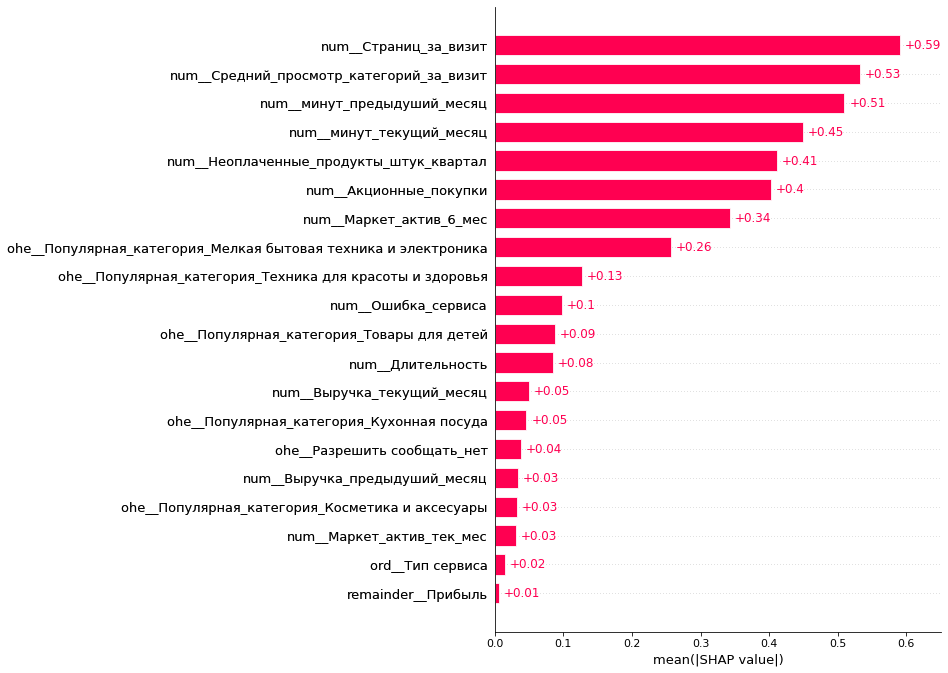

None

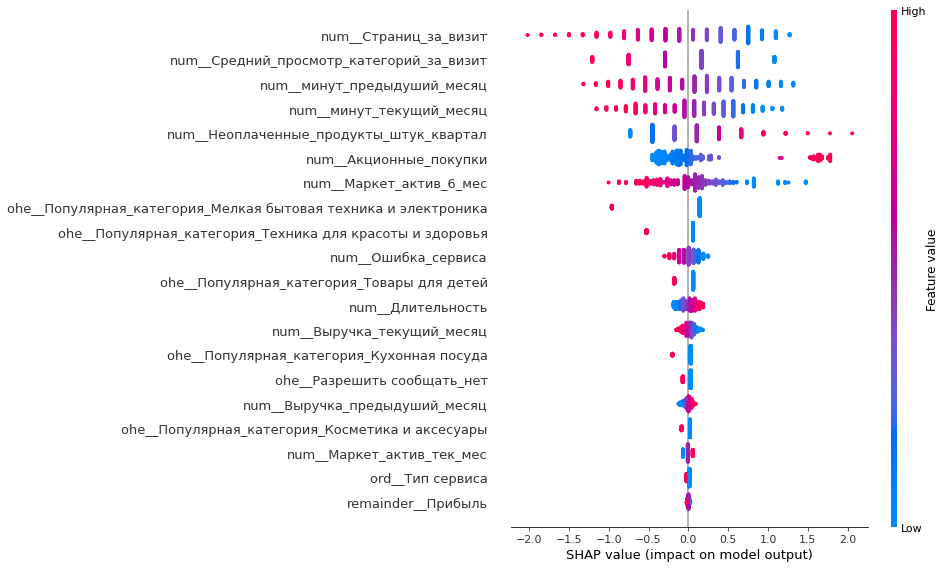

In [137]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2)

display(shap.plots.bar(shap_values, max_display=22))
shap.plots.beeswarm(shap_values, max_display=22) 

Теперь работает (Я увидел, что параметров для пайплайна больше все для деревьев решений. Было 2 параметра по 20 значений, итого 400 значений, для остальных моделей по 20. Почти всегда случайно выбиралось дерево решений.)

Теперь лучшей стала логистическая регрессия, поэтому все нарисовалось)

Средние `shap` значения

* `Страниц_за_визит` - 0,59
* `Средний_просмотр_категорий_за_визит` - 0,53
* `минут_предыдущий_месяц` - 0,51
* `минут_текущий_месяц` - 0,45
* `Неоплаченные_продукты_штук_квартал` - 0,41
* `Акционные покупки` - 0,4
* `Маркет_актив_6_мес` - 0,34
* `Популярная_категория_Мелкая бытовая техника и электроника` - 0,26
* `Популярная_категория_Техника для красоты и здоровья` - 0,13
* `Ошибка_сервиса` - 0,1
* `Популярная_категория_Товары для детей` - 0,09
* `Длительность` - 0,08
* `Выручка_текущий_месяц` - 0,05
* `Популярная_категория_Кухонная посуда` - 0,05
* `Разрешить сообщать_нет` - 0,04
* `Выручка_предыдущий_месяц` - 0,03
* `Популярная_категория_Косметика и аксессуары` - 0,03
* `Маркет_актив_тек_мес` - 0,03
* `Тип сервиса` - 0,02
* `Прибыль` - 0,01

Наиболее значимые признаки:

* `Страниц_за_визит` - 0,59
* `Средний_просмотр_категорий_за_визит` - 0,53
* `минут_предыдущий_месяц` - 0,51
* `минут_текущий_месяц` - 0,45
* `Неоплаченные_продукты_штук_квартал` - 0,41
* `Акционные покупки` - 0,4
* `Маркет_актив_6_мес` - 0,34
* `Популярная_категория_Мелкая бытовая техника и электроника` - 0,26

Самые важные признаки - информация об активности на сайте: `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `минут_предыдущий_месяц` и `минут_текущий_месяц`. Затем идет число неоплаченных покупок в корзине `Неоплаченные_продукты_штук_квартал`, доля покупок по акции `Акционные покупки`, `Маркет_актив_6_мес` и `Популярная_категория_Мелкая бытовая техника и электроника`.

Мало значимые признаки:

* `Выручка_текущий_месяц` - 0,05
* `Популярная_категория_Кухонная посуда` - 0,05
* `Разрешить сообщать_нет` - 0,04
* `Выручка_предыдущий_месяц` - 0,03
* `Популярная_категория_Косметика и аксессуары` - 0,03
* `Маркет_актив_тек_мес` - 0,03
* `Тип сервиса` - 0,02
* `Прибыль` - 0,01

Как это использовать?

Мы можем выделять пользователей потенциально склонных к снижению активности. 
Например, мы можем смотреть на наиболее информативные признаки (информация об активности на сайте - время и число страниц/категорий, есть ли покупки в категории *Мелкая бытовая техника и электроника*, какова доля покупок по акции). Если модель прогнозирует, что у этого человека активность должна снизиться, то мы можем сделать ему какое-то предложение, к примеру промокод, скидку, скорректировать рекомендации товаров.

У покупателя, активность которого снижена, обычно низкие показатели активности на сайте, много неоплаченных продуктов в корзине, высокая доля акционных товаров и мало покупок в категории *Мелкая бытовая техника и электроника*.

Тут я не очень понял, как именно использовать SHAP, так что сделал примерно как вот здесь 

https://www.geeksforgeeks.org/shap-with-a-linear-svc-model-from-sklearn-using-pipeline/

`Вывод Шаг 7:`

Был проведем анализ важности признаков с помощью SHAP. Среди наиболее важных признаков оказались:
* `Страниц_за_визит` - 0,59
* `Средний_просмотр_категорий_за_визит` - 0,53
* `минут_предыдущий_месяц` - 0,51
* `минут_текущий_месяц` - 0,45
* `Неоплаченные_продукты_штук_квартал` - 0,41
* `Акционные покупки` - 0,4
* `Маркет_актив_6_мес` - 0,34
* `Популярная_категория_Мелкая бытовая техника и электроника` - 0,26

Среди наименее важных:
* `Выручка_текущий_месяц` - 0,05
* `Популярная_категория_Кухонная посуда` - 0,05
* `Разрешить сообщать_нет` - 0,04
* `Выручка_предыдущий_месяц` - 0,03
* `Популярная_категория_Косметика и аксессуары` - 0,03
* `Маркет_актив_тек_мес` - 0,03
* `Тип сервиса` - 0,02
* `Прибыль` - 0,01

С помощью модели можем спрогнозировать, снизится активность пользователя или нет, и если снизится, то сделать пользователю спецпредложение (скидку, промокод и т.д.)

### Сегментация покупателей

In [138]:
data = market.drop(columns=['id'])

X_train, X_test, example_train, example_test = train_test_split(
    data.drop(['Покупательская активность'], axis=1),
    data['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['Покупательская активность'])

X = data.drop(['Покупательская активность'], axis=1)

#X_2 = pipe_final.named_steps['preprocessor'].fit_transform(X)

#feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

#X = pd.DataFrame(X_2, columns=feature_names)

probs = randomized_search.predict_proba(X)[:, 1]

market['Вероятность_снижения_активности'] = probs

display(market)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдуший_месяц,минут_текущий_месяц,минут_предыдуший_месяц,Прибыль,Вероятность_снижения_активности
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,10,12,4.16,0.867047
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,13,8,3.13,0.359525
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,13,11,4.87,0.768710
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,11,8,4.21,0.945244
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,10,10,3.95,0.732680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,7,14,4.44,0.056949
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,11,12,6.11,0.100137
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,18,12,3.29,0.290155
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,5224.6,4923.0,7,18,4.03,0.139709


Все пользователи в осях `Вероятность_снижения_активности` и `Прибыль`.

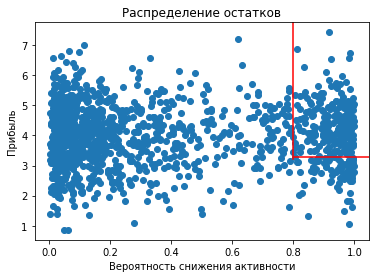

In [139]:
plt.scatter(market['Вероятность_снижения_активности'], \
            market['Прибыль'])
plt.title('Распределение остатков')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.axvline(0.8, 0.37, 1, \
            color='r', linestyle='-', label='vline')
plt.axhline(3.3, 0.775, 1, \
            color='r', linestyle='-', label='hline')
plt.show()

Красным отмечены пользователи с наибольшей прибылью и наибольшей вероятностью снижения активности.

In [140]:
threshold1 = 0.775
threshold2 = 3.3

chosen_segment = market[(market['Вероятность_снижения_активности'] > threshold1) & \
       (market['Прибыль'] >\
   threshold2)]

In [141]:
print(chosen_segment['Вероятность_снижения_активности'].min())
print(chosen_segment['Прибыль'].min())

0.7770173585902926
3.32


Выбрали именно этот сегмент, т.к. это наиболее важные в данной таблице пользователи - с высокой вероятностью снижения активности и прибылью выше среднего.

Визуализируем гистограммы распределения признаков в исходной таблице и в таблице сегмента

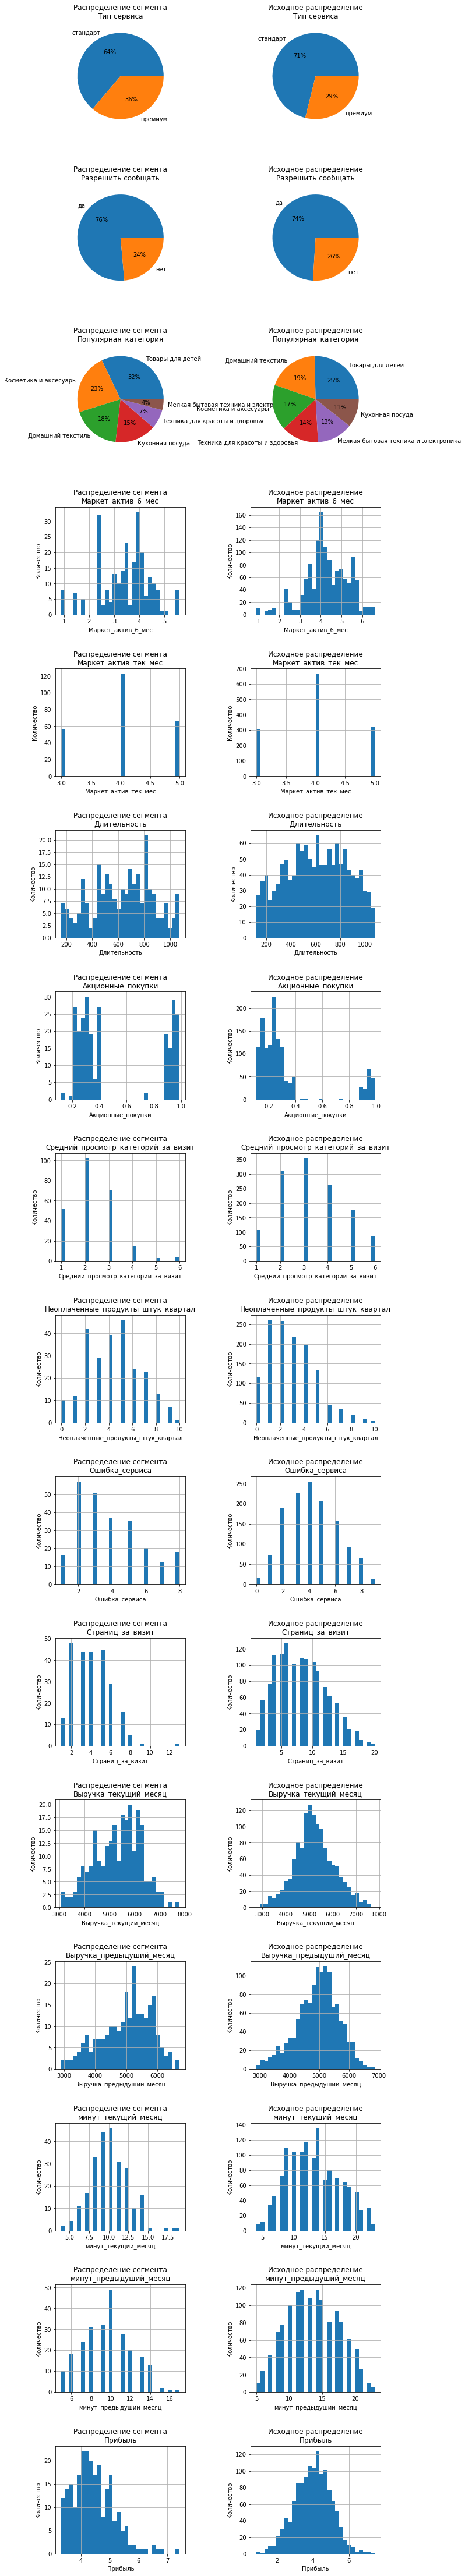

In [142]:
data = chosen_segment

categorial_columns = [
                      'Тип сервиса', 
                      'Разрешить сообщать',
                      'Популярная_категория'
                     ]

numerical_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 
         'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_текущий_месяц', 'Выручка_предыдуший_месяц', 
         'минут_текущий_месяц', 'минут_предыдуший_месяц', 'Прибыль']

df_columns = []
df_columns.extend(categorial_columns)
df_columns.extend(numerical_columns)

fig = plt.figure(figsize=(10, 80));
for i, column in enumerate(df_columns):
    plt.subplot(16, 2, 2*i+1)
    if column in categorial_columns:
        chosen_segment[column].value_counts().plot(
    kind= 'pie',
    title= 'Распределение сегмента\n'+df_columns[i],
    autopct = "%.0f%%",
    ylabel= ""
)
    else:
        plt.hist(chosen_segment[column], bins=30)
        plt.title('Распределение сегмента\n'+df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
        
    plt.subplot(16, 2, 2*i+2)
    if column in categorial_columns:
        market[column].value_counts().plot(
    kind= 'pie',
    title= 'Исходное распределение\n'+df_columns[i],
    autopct = "%.0f%%",
    ylabel= ""
)
    else:
        plt.hist(market[column], bins=30)
        plt.title('Исходное распределение\n'+df_columns[i])
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid()
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show();

Столбцы, где есть явная разница:
* `Популярная_категория` - представители исследуемого сегмента почти не покупают товары из категорий *Техника для красоты и здоровья* и *Мелкая бытовая техника и электроника*
* `Акционные_покупки` - около трети исследуемой группы покупает почти все товары именно по акции
* `Средний_просмотр_категорий_за_визит` - исследуемая группа просматривает в основном от 1 до 3 категорий
* `Страниц_за_визит` - исследуемый сегмент в основном просматривает не более 6 страниц за раз

Рекомендации по работе с сегментом:
* Улучшить рекомендации товаров для этих пользователей. Больше и точнее рекомендовать этим пользователям товары из категории `Техника для красоты и здоровья` и `Мелкая бытовая техника и электроника`
* Предлагать этим пользователям больше товаров по акции. Немалая часть этого сегмента предпочитает товары исключительно по акции. Можно как обращать внимание клиентов на имеющиеся акции, так и вводить новые специально для этой группы.

`Вывод Шаг 8:`

Была выбрана группа с предсказанной вероятностью снижения активности > 0.37 и суммарной выручкой за 2 месяца, большей 9126. Группа была выбрана по графику.

Для данного сегмента пользователей рекомендуется улучшать рекомендации товаров из категорий `Техника для красоты и здоровья` и `Мелкая бытовая техника и электроника`.

### Общий вывод 

Была поставлена задача анализа пользователей интернет-магазина «В один клик» для повышения их активности, а также разработки решения для увеличения покупательской активности постоянных клиентов с помощью персональных предложений.

Исходные данные состояли из четырёх таблиц - `market_file`, `market_money`, `market_time` и `money` с общей информацией, выручке за последние 3 месяца, времени на сайте и прибыли от каждого пользователя. Каждая из таблиц была проверена на наличие пропусков и явных дупликатов, а также на правильность типов значений в столбцах. Все таблицы были собраны в единую таблицу `market`.

Распределения всех признаков были визуализированы на гистограммах, также отдельно были рассмотрены распределения признаков для пользователей с разным уровнем активности. 

Был реализован пайплайн для выбора лучшей модели для данной задачи. В пайплайне проверялись модели `k ближайших соседей`, `дерева решений`, `логистической регрессии` и `опорных векторов`, для каждой модели проверялось 20 наборов гиперпараметров для выбора лучшей.

Лучшей моделью по итогу работы пайплайна оказалась модель `логистической регрессии` с Лассо-регуляризацией и параметром регуляризации `C=8`. Эта модель показала значение метрики `roc-auc` равный 0.916 на тестовой выборки, что является очень хорошим результатом.

Был рассмотрен сегмент покупателей с высокой вероятностью снижения активности, которая была предсказана лучшей моделью, а также с прибылью для компании выше среднего. Для данного сегмента было выявлено, что покупатели практически игнорируют категории *Техника для красоты и здоровья* и *Мелкая бытовая техника и электроника*, а также часто покупают товары по акции. Для повышения активности этого сегмента пользователей рекомендуется обращать их внимание на товары по акции, запускать новые акции специально для этого сегмента пользователей, а также настроить рекомендательную систему для рекомендации этим покупателям товаров из категорий *Техника для красоты и здоровья* и *Мелкая бытовая техника и электроника*.

